In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

'/home/nils/projects/uq-method-box'

In [8]:
from uq_method_box.datamodules import ToyHeteroscedasticDatamodule
from uq_method_box.models import MLP
from uq_method_box.uq_methods import (
    BaseModel,
    CQR,
    MCDropoutModel,
    QuantileRegressionModel,
    LaplaceModel,
    DeepEnsembleModel,
)
from lightning import Trainer

import matplotlib.pyplot as plt
import torch
import numpy as np
import tempfile

from uq_method_box.viz_utils import (
    plot_toy_data,
    plot_predictions,
    plot_calibration_uq_toolbox,
)

from uq_method_box.train_utils import basic_train_loop, NLL, QuantileLoss

from uq_method_box.eval_utils import compute_empirical_coverage

temp_dir = tempfile.mkdtemp()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
plt.rcParams["figure.figsize"] = [28, 9]

In [10]:
dm = ToyHeteroscedasticDatamodule()
X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

X_test_cpu = torch.clone(X_test).numpy()
y_test_cpu = torch.clone(y_test).numpy()

# Base Model

In [17]:
base_config = {
    "model": {"model_name": "mlp", "model_args": {"n_hidden": [50]}, "loss_fn": "mse"},
    "optimizer": {"lr": 1e-2},
}
base_model = BaseModel(
    MLP,
    model_args=base_config["model"]["model_args"],
    lr=base_config["optimizer"]["lr"],
    loss_fn="mse",
    save_dir=None,
)
trainer = Trainer(max_epochs=300, limit_val_batches=0, num_sanity_val_steps=0)
trainer.fit(base_model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.7 K 
4 | criterion     | MSELoss          | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [14]:
# get predictions
with torch.no_grad():
    y_preds_det = base_model(X_test)

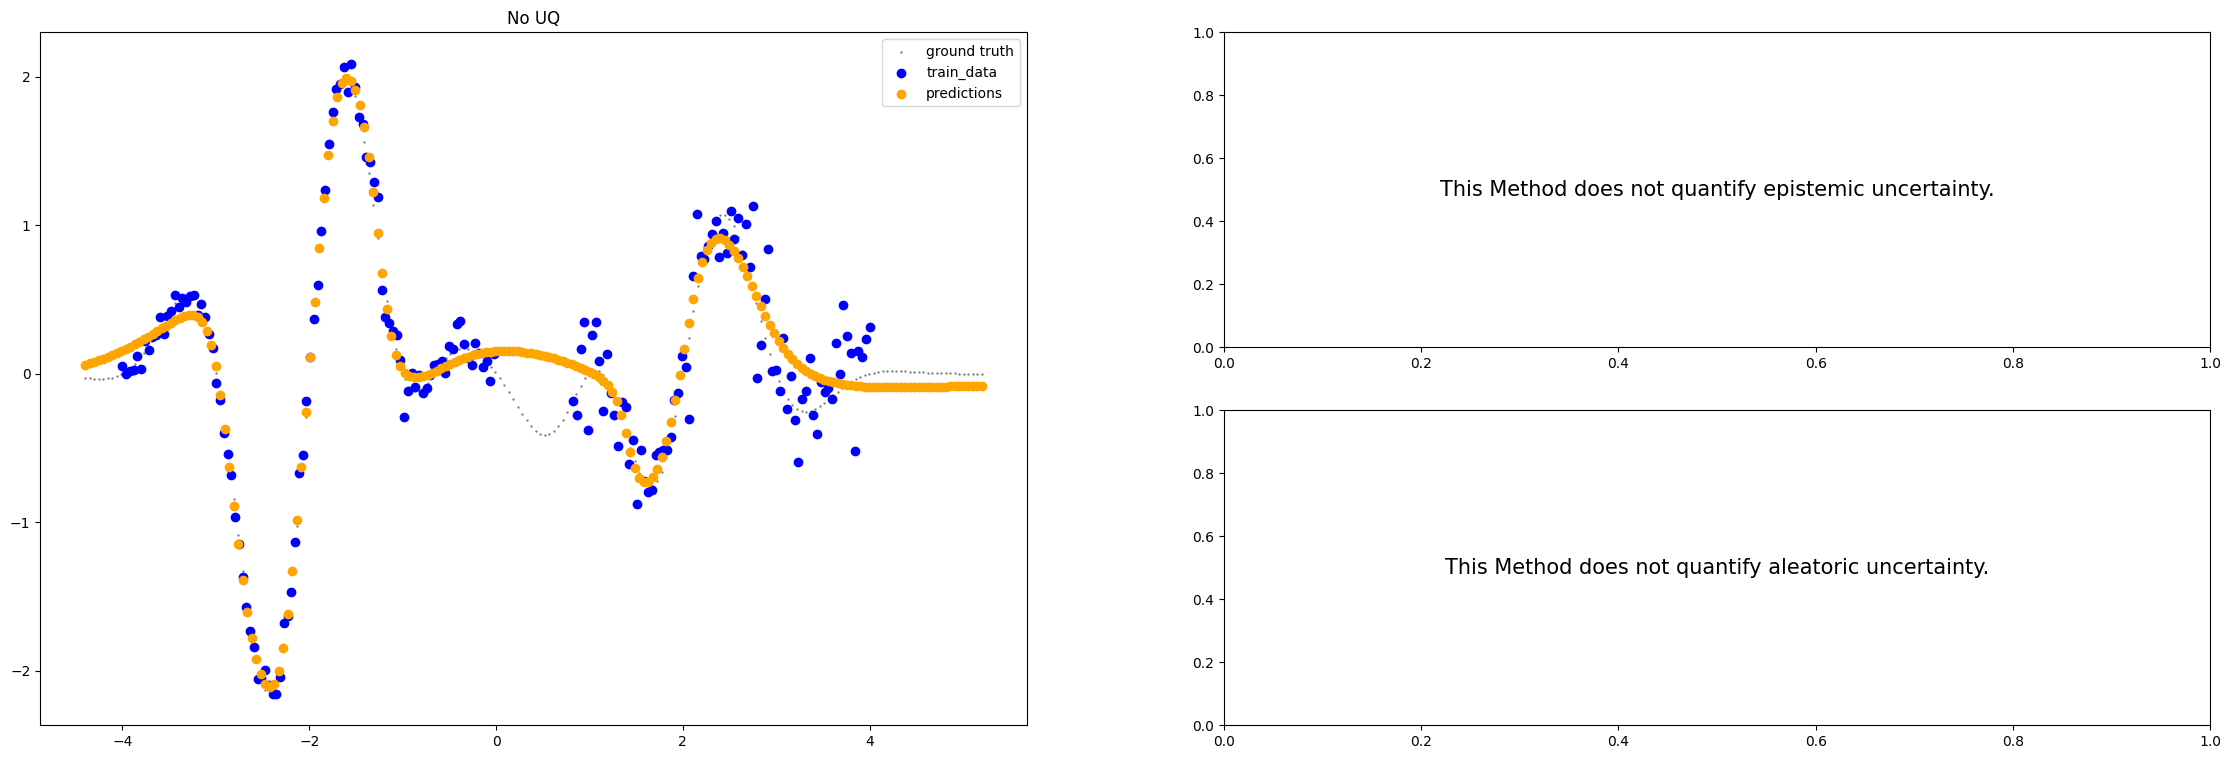

In [15]:
# plot predictions
plot_predictions(X_train, y_train, X_test_cpu, y_test_cpu, y_preds_det, title="No UQ")

# MC Dropout

In [18]:
mc_config = {
    "model": {
        "model_name": "mlp",
        "mc_samples": 20,
        "model_args": {
            "n_outputs": 2,
            "dropout_p": 0.1,
            "n_hidden": [50, 50, 50],
            "predict_sigma": True,
        },
        "loss_fn": "nll",
    },
    "optimizer": {"lr": 1e-2},
}
mc_droput_model = MCDropoutModel(
    MLP,
    model_args=mc_config["model"]["model_args"],
    num_mc_samples=mc_config["model"]["mc_samples"],
    lr=mc_config["optimizer"]["lr"],
    loss_fn=mc_config["model"]["loss_fn"],
    save_dir=None,
)

trainer = Trainer(max_epochs=200, limit_val_batches=0, num_sanity_val_steps=0)
trainer.fit(mc_droput_model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 7.9 K 
4 | criterion     | NLL              | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [19]:
# get predictions
with torch.no_grad():
    out = mc_droput_model.predict_step(X_test)
    mc_mean_nll = out["mean"]
    mc_std_nll = out["pred_uct"]
    mc_epistemic = out["epistemic_uct"]
    mc_aleatoric = out["aleatoric_uct"]

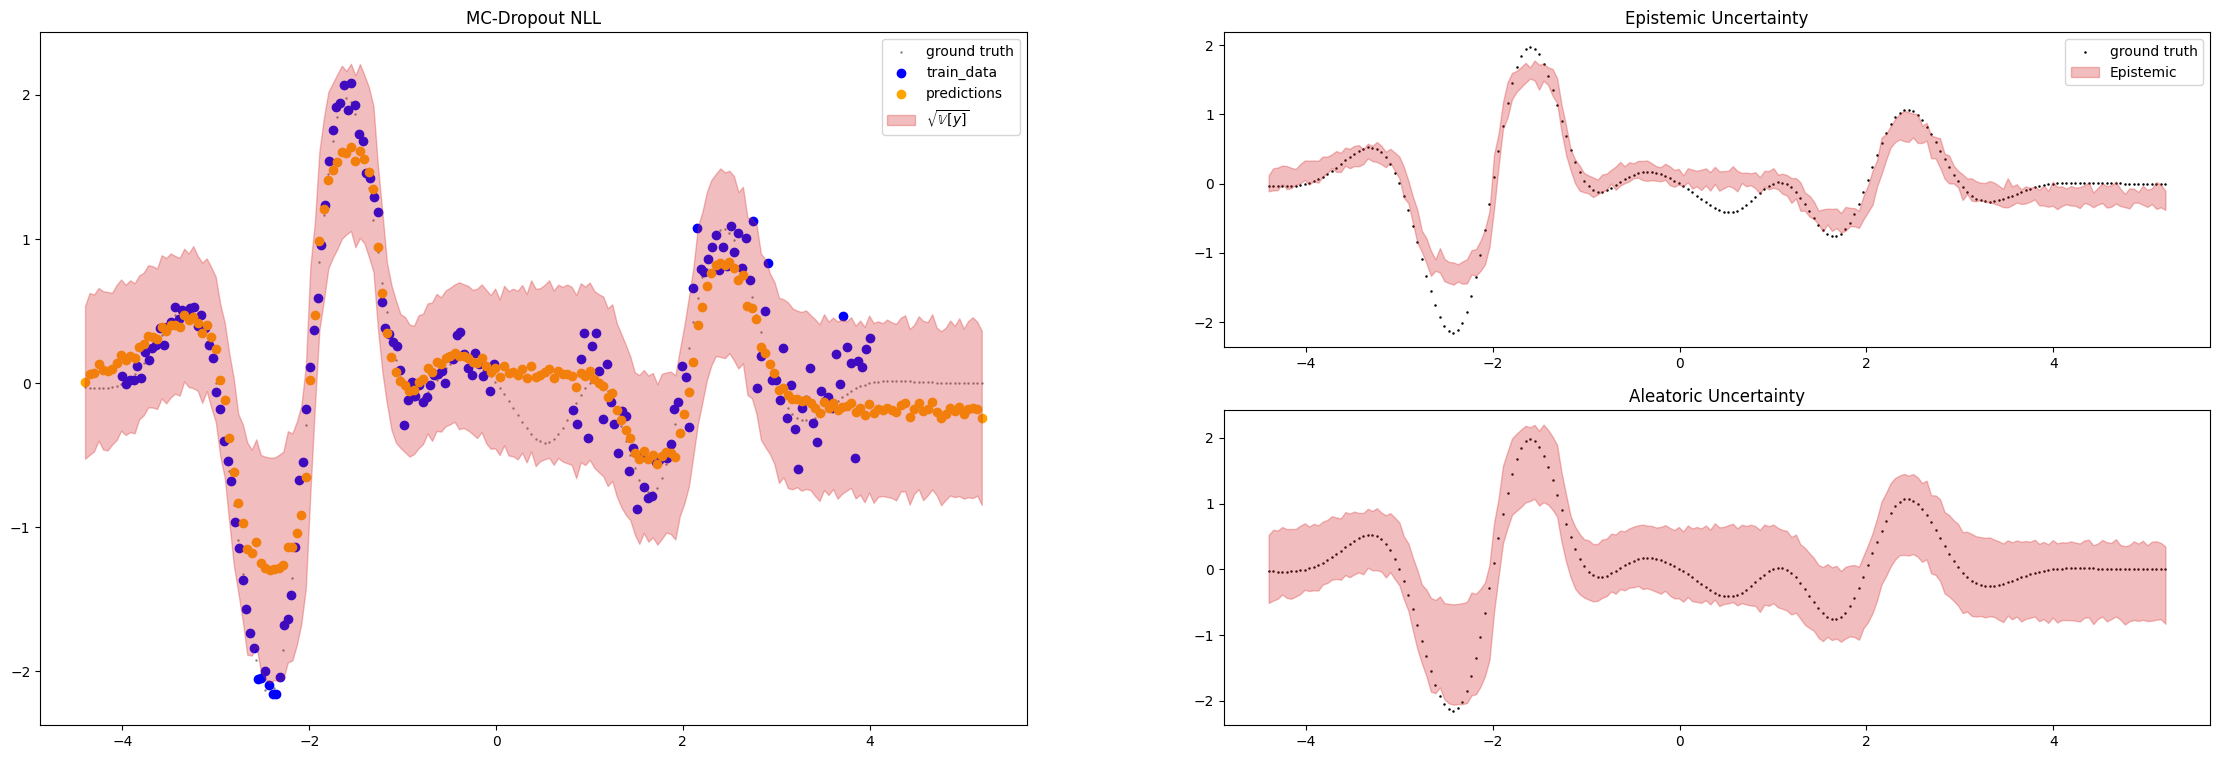

<Figure size 2800x900 with 0 Axes>

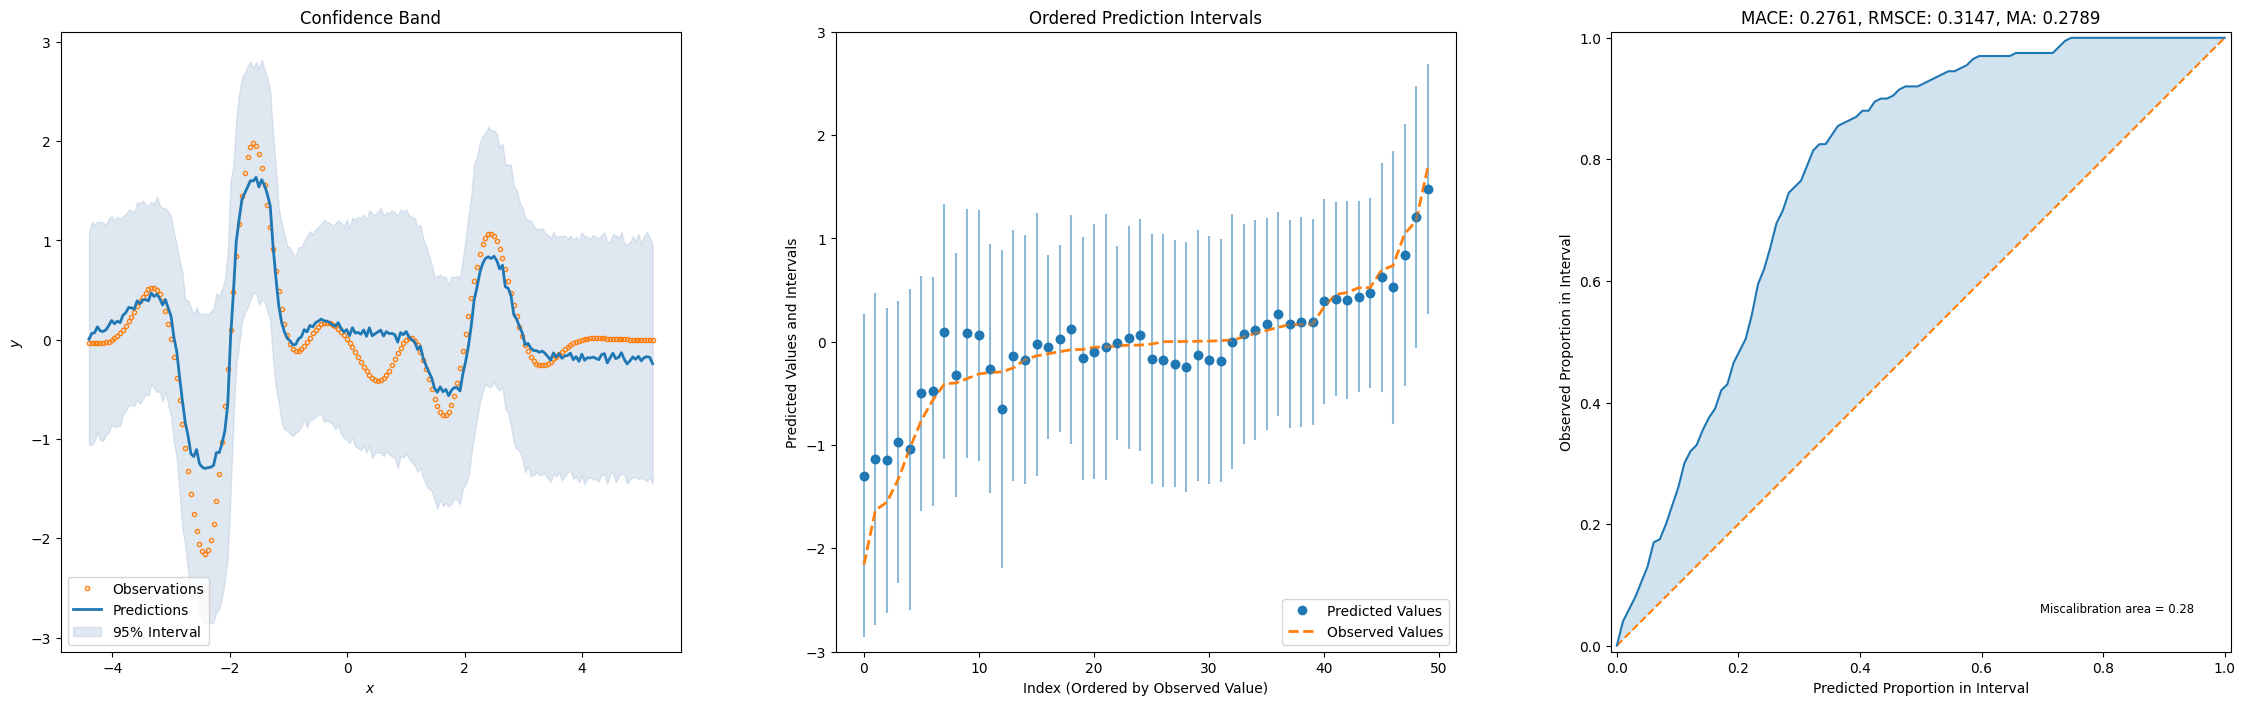

In [20]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mc_mean_nll,
    mc_std_nll,
    epistemic=mc_epistemic,
    aleatoric=mc_aleatoric,
    title="MC-Dropout NLL",
)
plot_calibration_uq_toolbox(mc_mean_nll, mc_std_nll, y_test_cpu, X_test_cpu)

# Quantile Regression

In [21]:
quantiles = [0.1, 0.5, 0.9]
qr_config = {
    "model": {
        "model_name": "mlp",
        "model_args": {"n_outputs": len(quantiles), "n_hidden": [50, 50, 50]},
        "quantiles": quantiles,
        "loss_fn": "quantile",
    },
    "optimizer": {"lr": 1e-2},
}

qr_model = QuantileRegressionModel(
    MLP,
    qr_config["model"]["model_args"],
    lr=qr_config["optimizer"]["lr"],
    save_dir=None,
    quantiles=quantiles,
)

trainer = Trainer(max_epochs=200, limit_val_batches=0, num_sanity_val_steps=0)
trainer.fit(qr_model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 7.9 K 
4 | criterion     | QuantileLoss     | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [22]:
# get predictions
with torch.no_grad():
    out = qr_model.predict_step(X_test)
    qr_mean = out["mean"]
    qr_median = out["median"]
    qr_std = out["pred_uct"]
    qr_aleatoric = out["aleatoric_uct"]
    quantile_preds = np.stack(
        [out["lower_quant"], qr_mean, out["upper_quant"]], axis=-1
    )

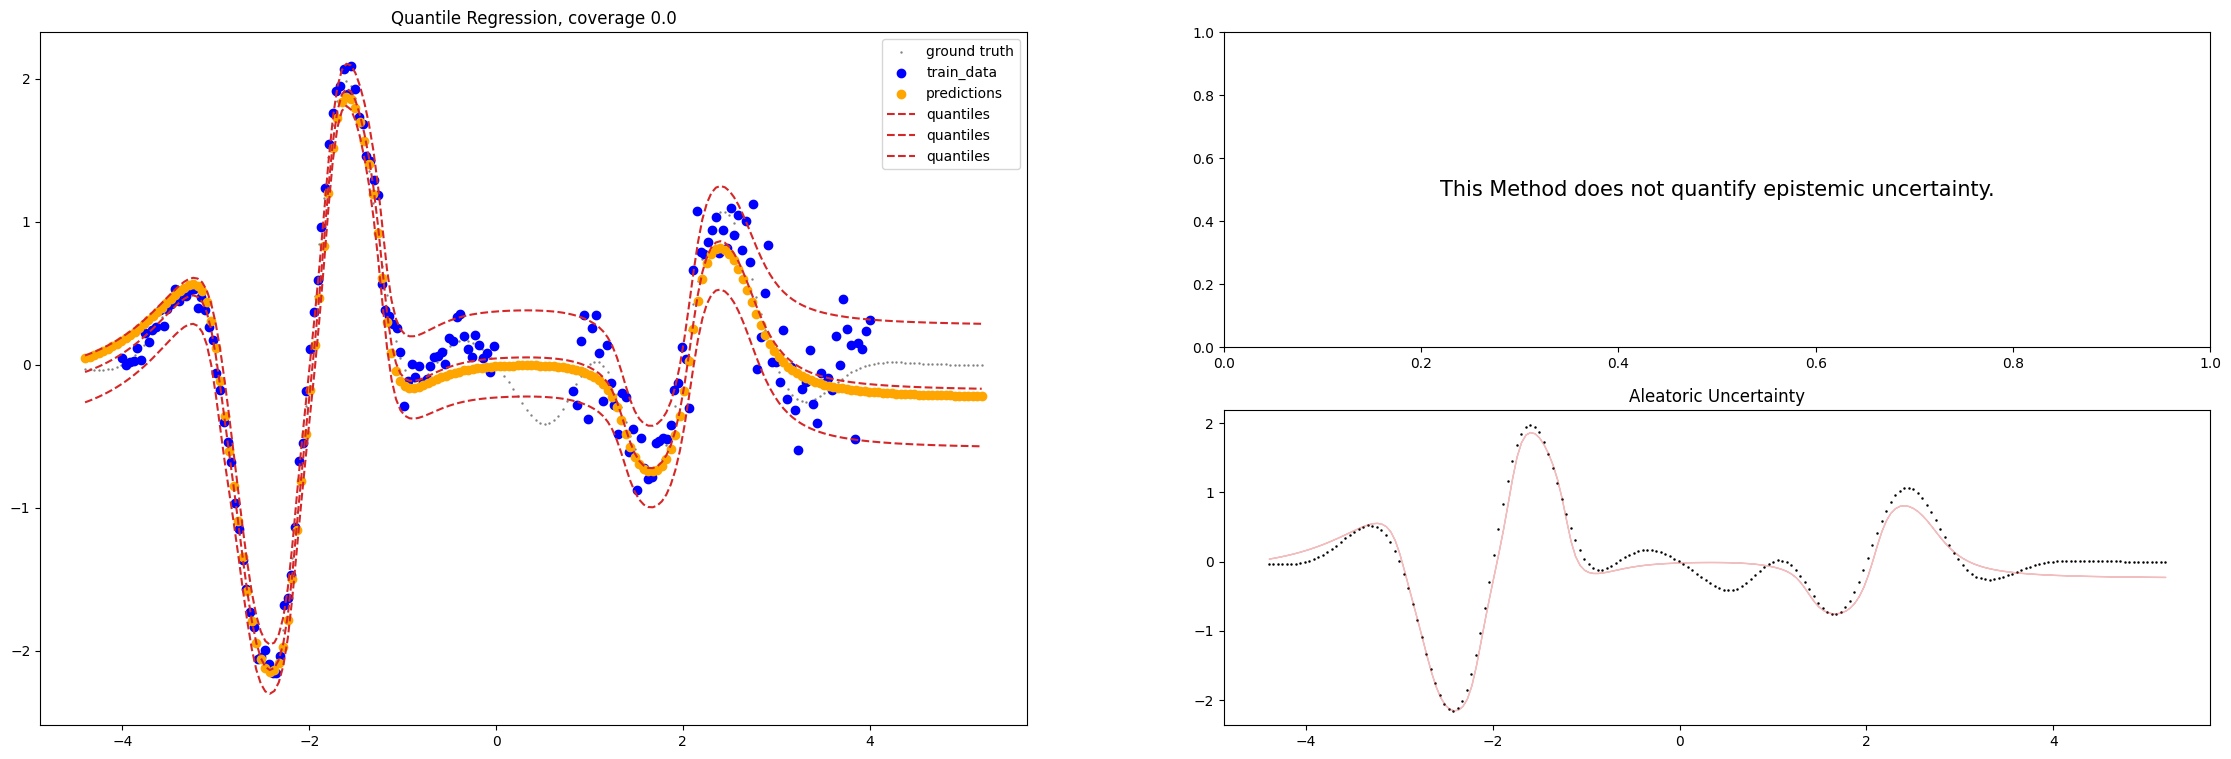

<Figure size 2800x900 with 0 Axes>

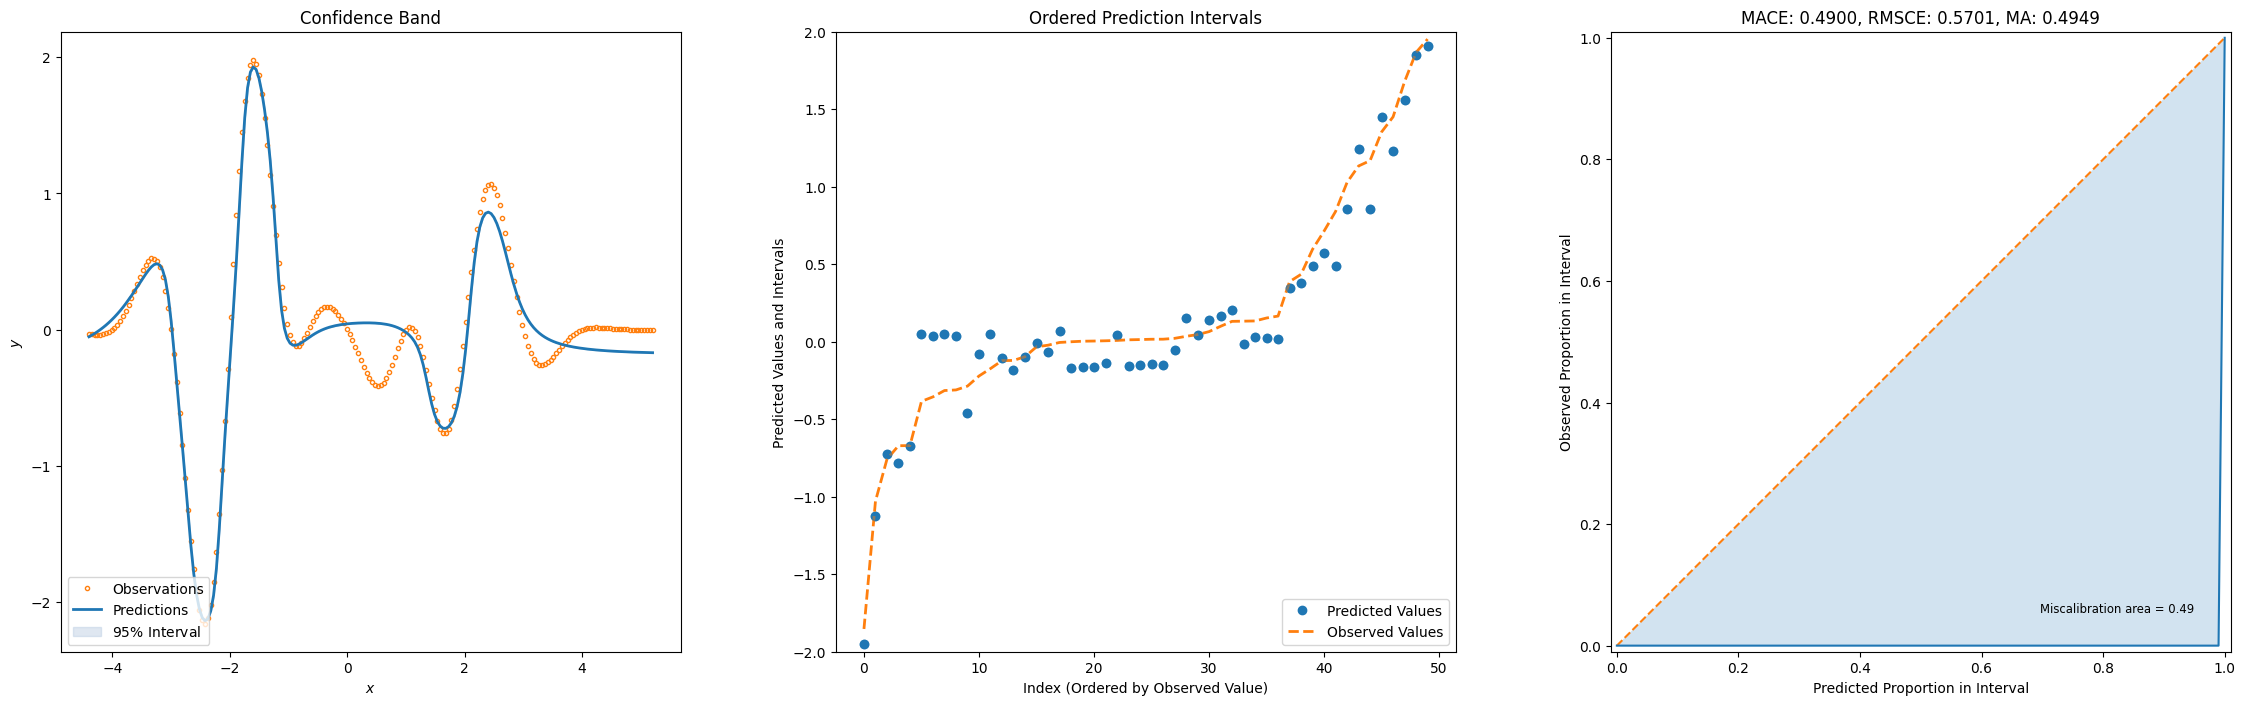

In [23]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    qr_median,
    pred_quantiles=quantile_preds,
    aleatoric=qr_aleatoric,
    title=f"Quantile Regression, coverage {compute_empirical_coverage(quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(qr_mean, qr_std, y_test_cpu, X_test_cpu)

# conformalized Quantile Regression

In [25]:
# wrapper around Quantile Regression Model
cqr = CQR(qr_model, quantiles, test_loader, save_dir=None)

# get predictions
with torch.no_grad():
    out = cqr.predict_step(X_test)
    cqr_mean = out["mean"]
    cqr_std = out["pred_uct"]
    cqr_aleatoric = out["aleatoric_uct"]
    cqr_quantile_preds = np.stack(
        [out["lower_quant"], cqr_mean, out["upper_quant"]], axis=-1
    )

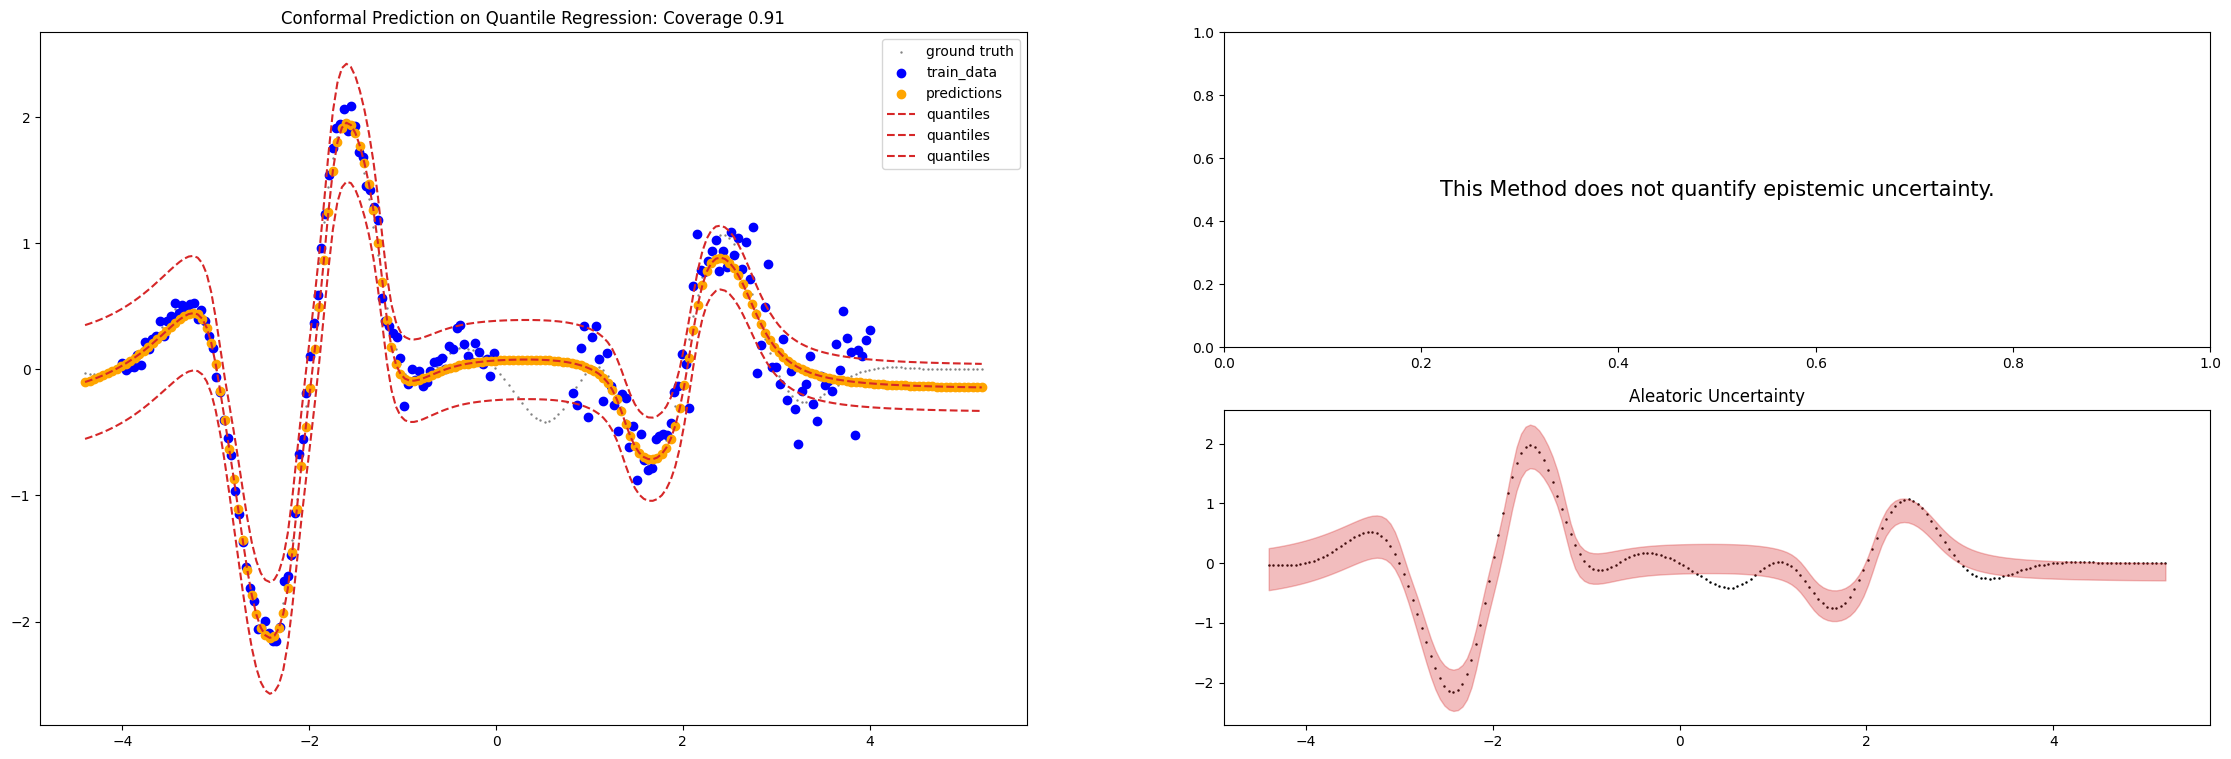

<Figure size 2800x900 with 0 Axes>

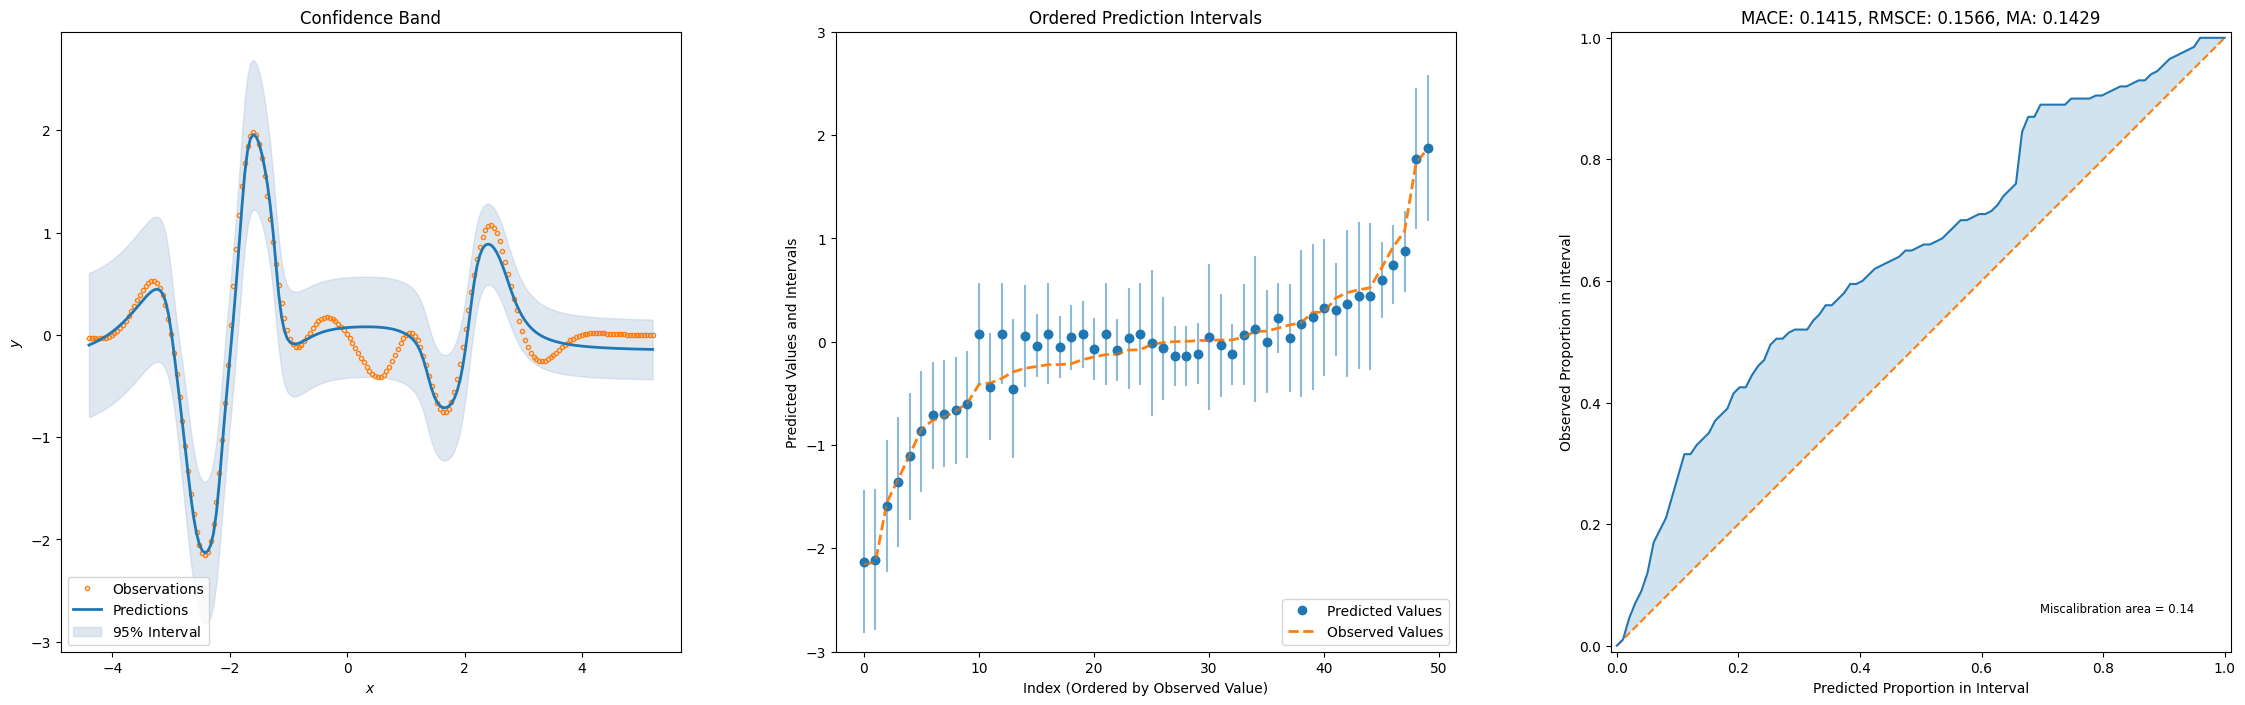

In [26]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    cqr_mean,
    pred_quantiles=cqr_quantile_preds,
    aleatoric=cqr_aleatoric,
    title=f"Conformal Prediction on Quantile Regression: Coverage {compute_empirical_coverage(cqr_quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(cqr_mean, cqr_std, y_test_cpu, X_test_cpu)

# Laplace Approximation

TODO: need to fix this implementation

In [41]:
laplace_config = {
    "model": {
        "model_name": "laplace_mlp",
        "laplace": {
            "prior_mean": 0,
            "prior_precision": 1,
            "subset_of_weights": "all",
            "hessian_structure": "full",
            "tune_precision_lr": 0.1,
            "n_epochs_tune_precision": 100,
        },
    },
    "optimizer": {"lr": 1e-2},
}

laplace = LaplaceModel(
    base_model, laplace_config["model"]["laplace"], train_loader, save_dir=None
)


la_out = laplace.predict_step(X_test)
la_mean = la_out["mean"]
la_predictive = la_out["pred_uct"]
la_epistemic = la_out["epistemic_uct"]
la_aleatoric = la_out["aleatoric_uct"]

100%|██████████| 100/100 [00:37<00:00,  2.65it/s, neg_marglik=69.10591888427734]


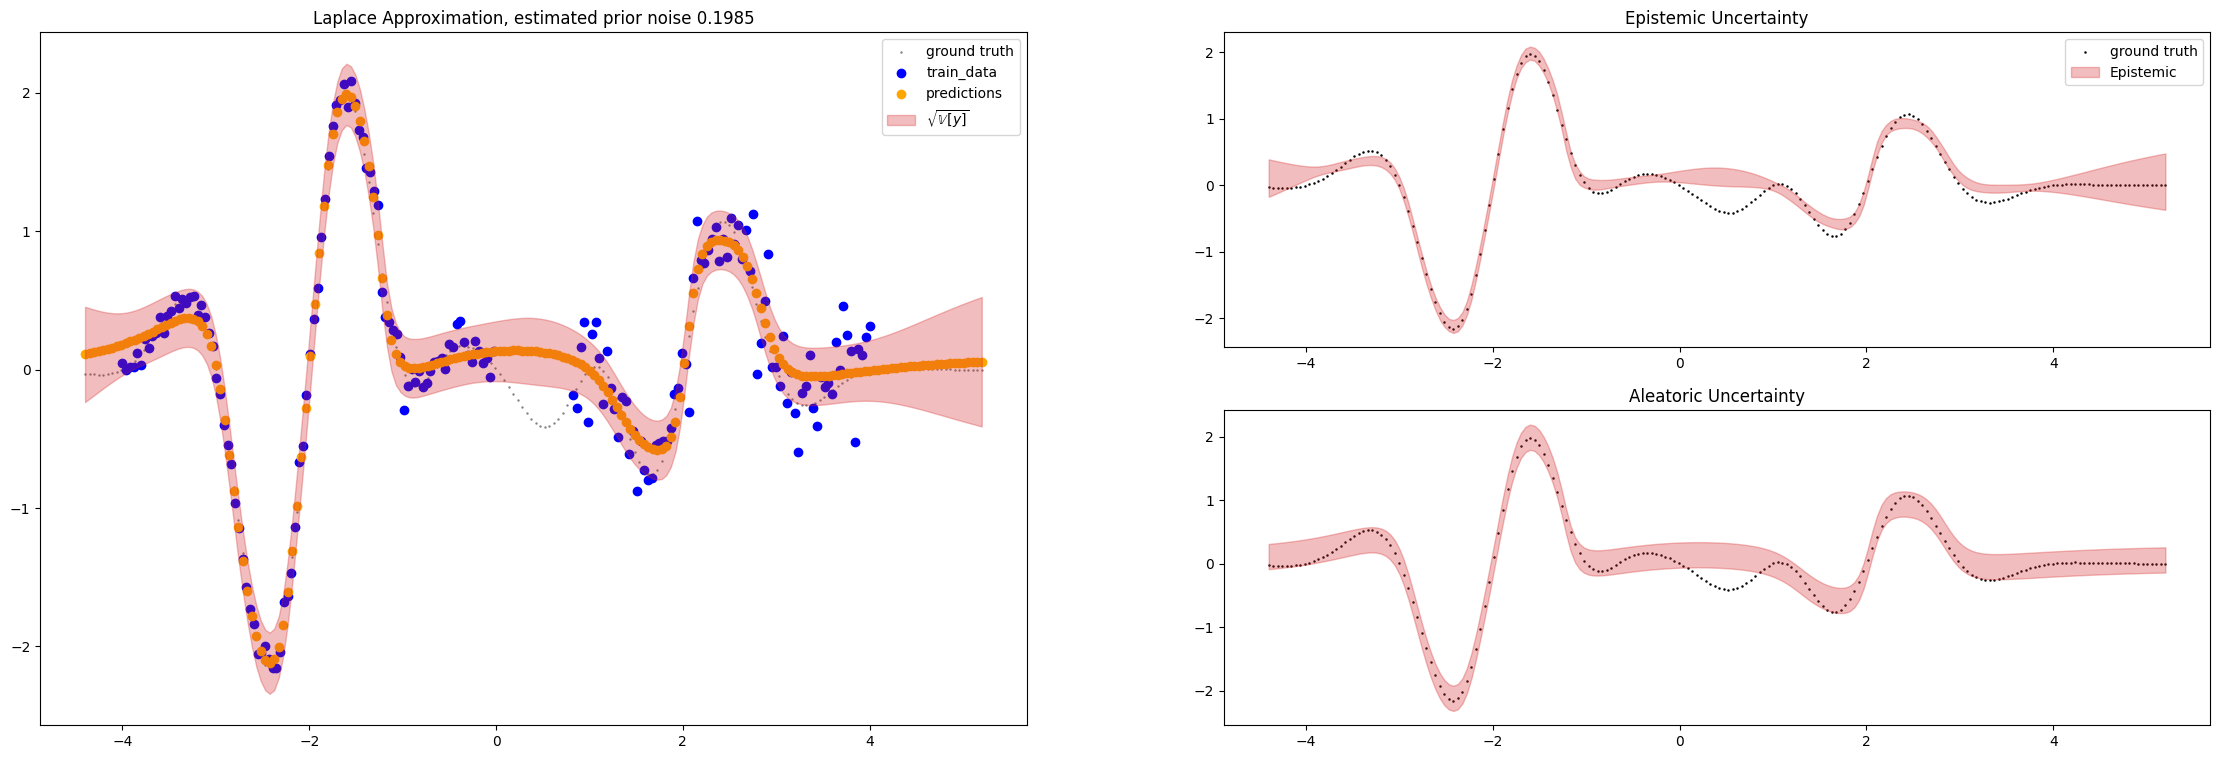

<Figure size 2800x900 with 0 Axes>

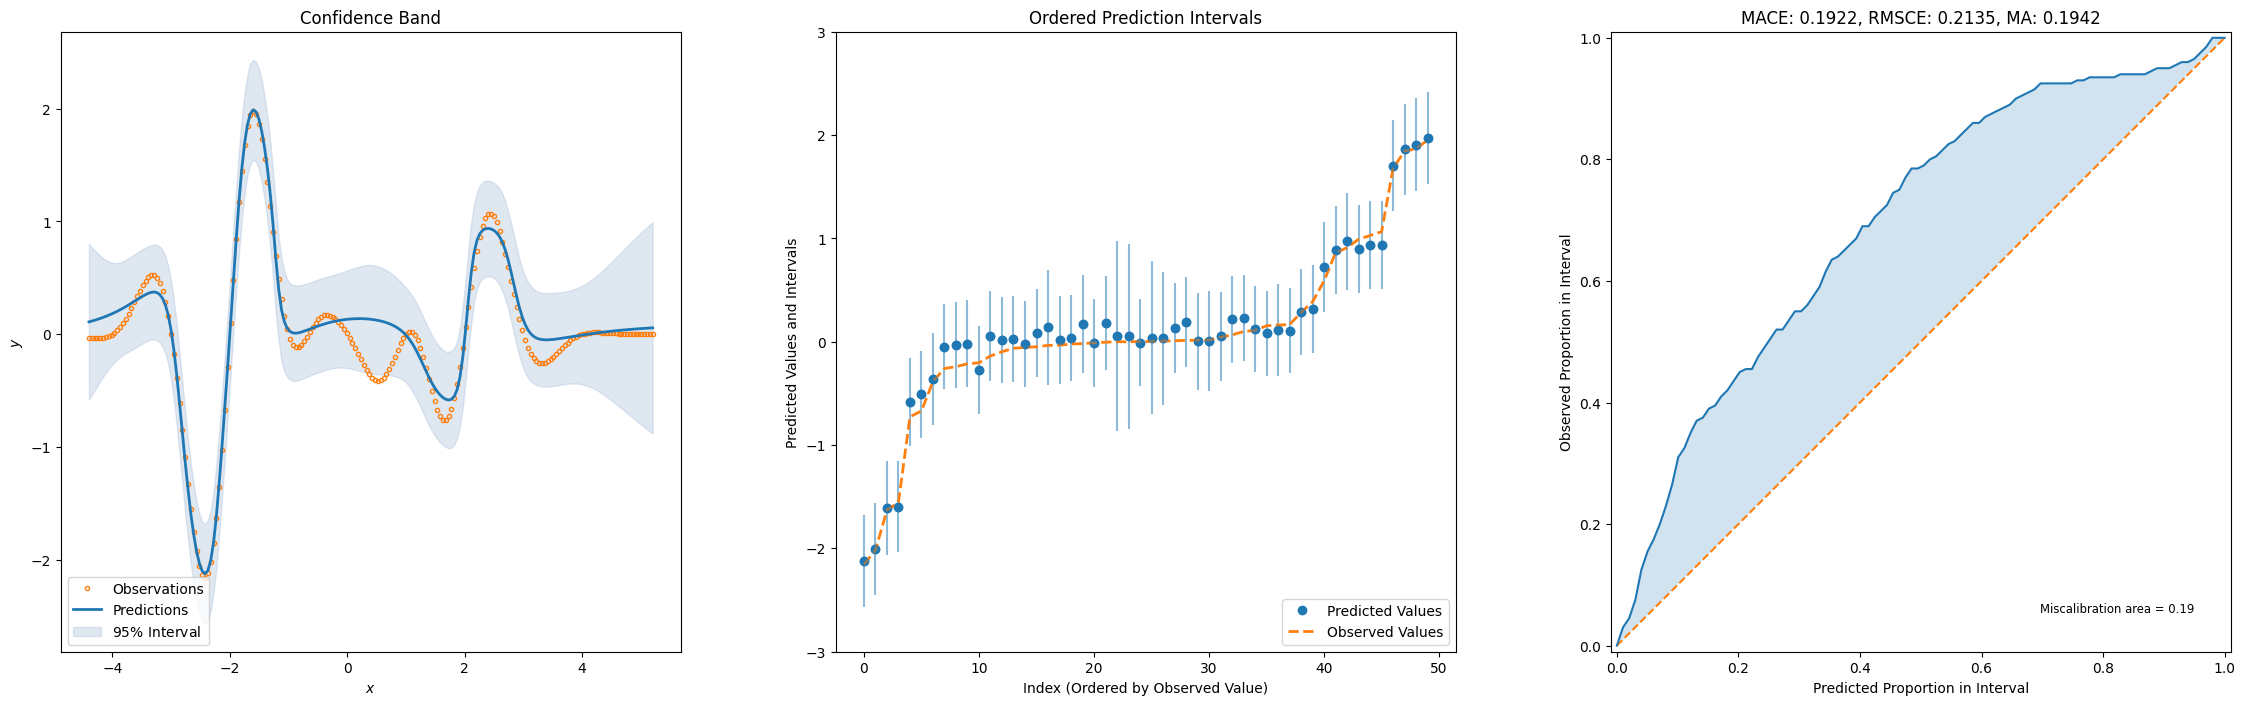

In [42]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    la_mean,
    la_predictive,
    epistemic=la_epistemic,
    aleatoric=la_aleatoric,
    title=f"Laplace Approximation, estimated prior noise {la_aleatoric.mean():.4f}",
)
plot_calibration_uq_toolbox(la_mean, la_predictive, y_test_cpu, X_test_cpu)

# Deep Ensemble

## MSE

In [30]:
n_ensembles = 5
trained_model_paths = []
for i in range(n_ensembles):
    ensemble_member = BaseModel(
        MLP,
        model_args=base_config["model"]["model_args"],
        lr=base_config["optimizer"]["lr"],
        loss_fn="mse",
        save_dir=None,
    )
    trainer = Trainer(max_epochs=200, limit_val_batches=0, num_sanity_val_steps=0)
    trainer.fit(ensemble_member, dm)
    save_path = os.path.join(temp_dir, f"model_mse_{i}.ckpt")
    trainer.save_checkpoint(save_path)
    trained_model_paths.append({"model_class": BaseModel, "ckpt_path": save_path})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.7 K 
4 | criterion     | MSELoss          | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.7 K 
4 | criterion     | MSELoss          | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.7 K 
4 | criterion     | MSELoss          | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.7 K 
4 | criterion     | MSELoss          | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.7 K 
4 | criterion     | MSELoss          | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [19]:
os.listdir(temp_dir)

['model_mse_0.ckpt',
 'model_mse_2.ckpt',
 'model_mse_3.ckpt',
 'model_mse_4.ckpt',
 'model_mse_1.ckpt']

In [31]:
# get predictions with ensemble wrapper
deep_ens = DeepEnsembleModel(trained_model_paths, save_dir=None)
with torch.no_grad():
    out = deep_ens.predict_step(X_test)
    mse_de_mean = out["mean"]
    mse_de_std = out["pred_uct"]
    de_epistemic_mse = out["epistemic_uct"]

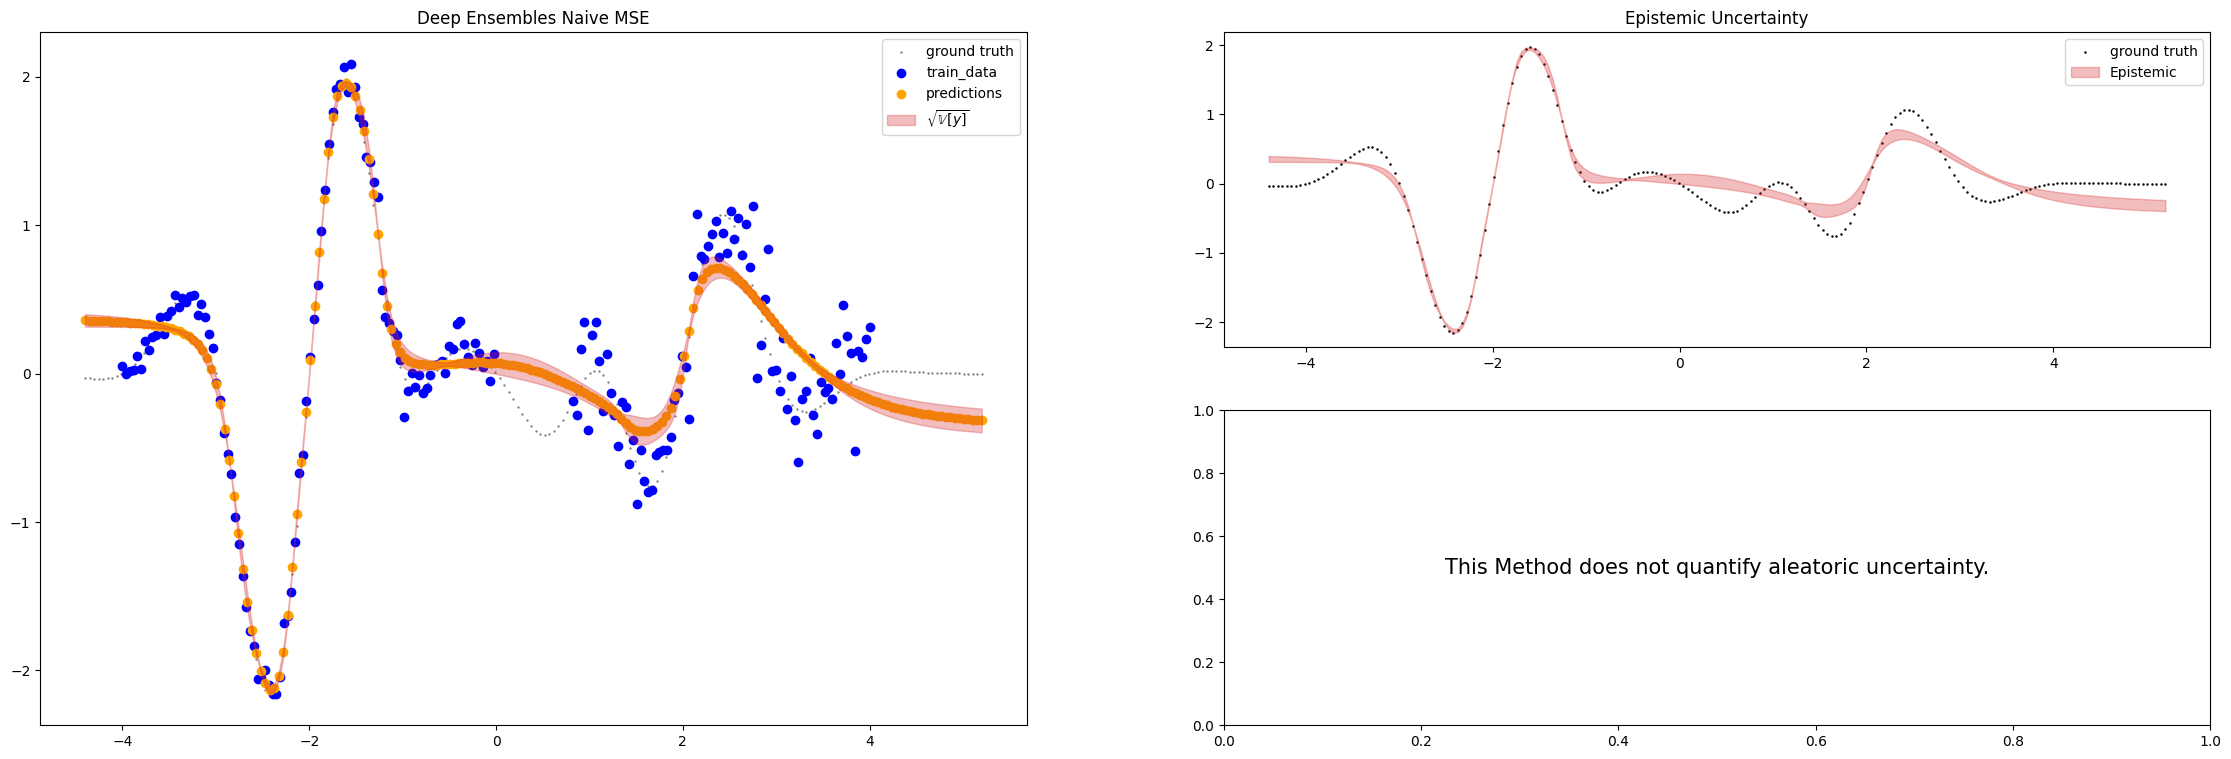

<Figure size 2800x900 with 0 Axes>

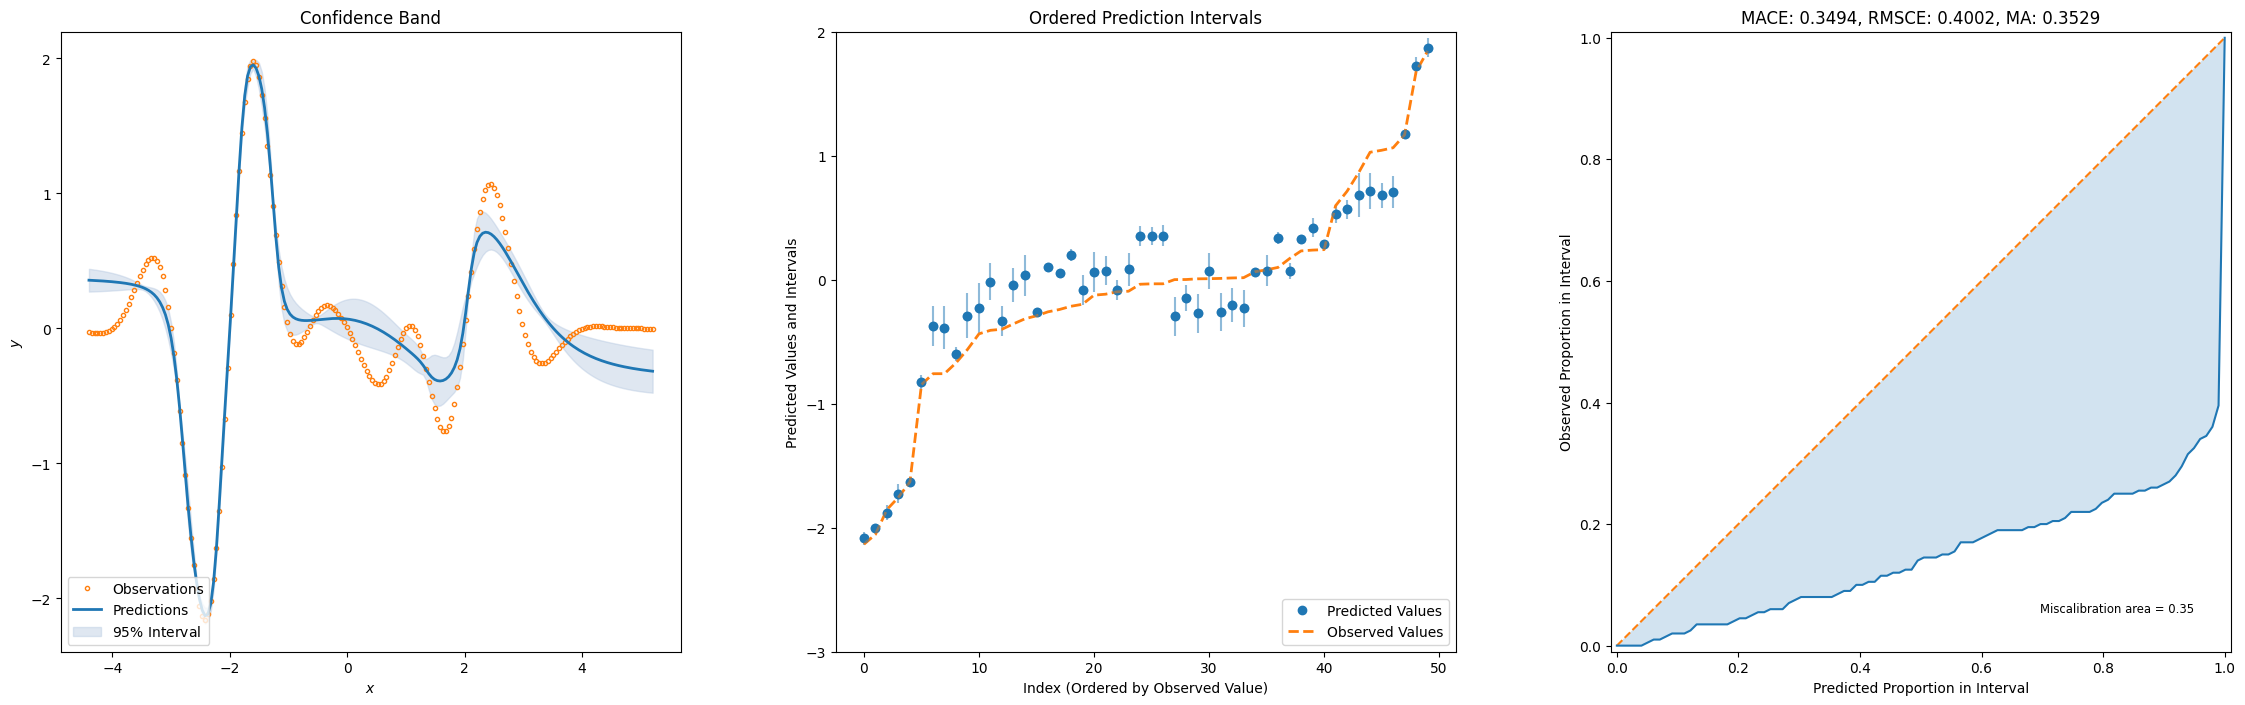

In [32]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mse_de_mean,
    mse_de_std,
    epistemic=mse_de_std,
    title="Deep Ensembles Naive MSE",
)
plot_calibration_uq_toolbox(mse_de_mean, mse_de_std, y_test_cpu, X_test_cpu)

## NLL

In [33]:
nll_config = {
    "model": {
        "model_name": "mlp",
        "mc_samples": 20,
        "model_args": {"n_outputs": 2, "n_hidden": [50, 50, 50], "predict_sigma": True},
        "loss_fn": "nll",
    },
    "optimizer": {"lr": 1e-2},
}

n_ensembles = 5
trained_models_nll = []
for i in range(n_ensembles):
    ensemble_member = BaseModel(
        MLP,
        model_args=nll_config["model"]["model_args"],
        lr=nll_config["optimizer"]["lr"],
        loss_fn="nll",
        save_dir=None,
    )
    trainer = Trainer(max_epochs=200, limit_val_batches=0, num_sanity_val_steps=0)
    trainer.fit(ensemble_member, dm)
    save_path = os.path.join(temp_dir, f"model_nll_{i}.ckpt")
    trainer.save_checkpoint(save_path)
    trained_models_nll.append({"model_class": BaseModel, "ckpt_path": save_path})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 7.9 K 
4 | criterion     | NLL              | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 7.9 K 
4 | criterion     | NLL              | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 7.9 K 
4 | criterion     | NLL              | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 7.9 K 
4 | criterion     | NLL              | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 7.9 K 
4 | criterion     | NLL              | 0     
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [34]:
# get predictions with ensemble wrapper
deep_ens_nll = DeepEnsembleModel(trained_models_nll, None)
with torch.no_grad():
    out = deep_ens_nll.predict_step(X_test)
    nll_de_mean = out["mean"]
    nll_de_std = out["pred_uct"]
    nll_epistemic_de = out["epistemic_uct"]
    nll_aleatoric_de = out["aleatoric_uct"]

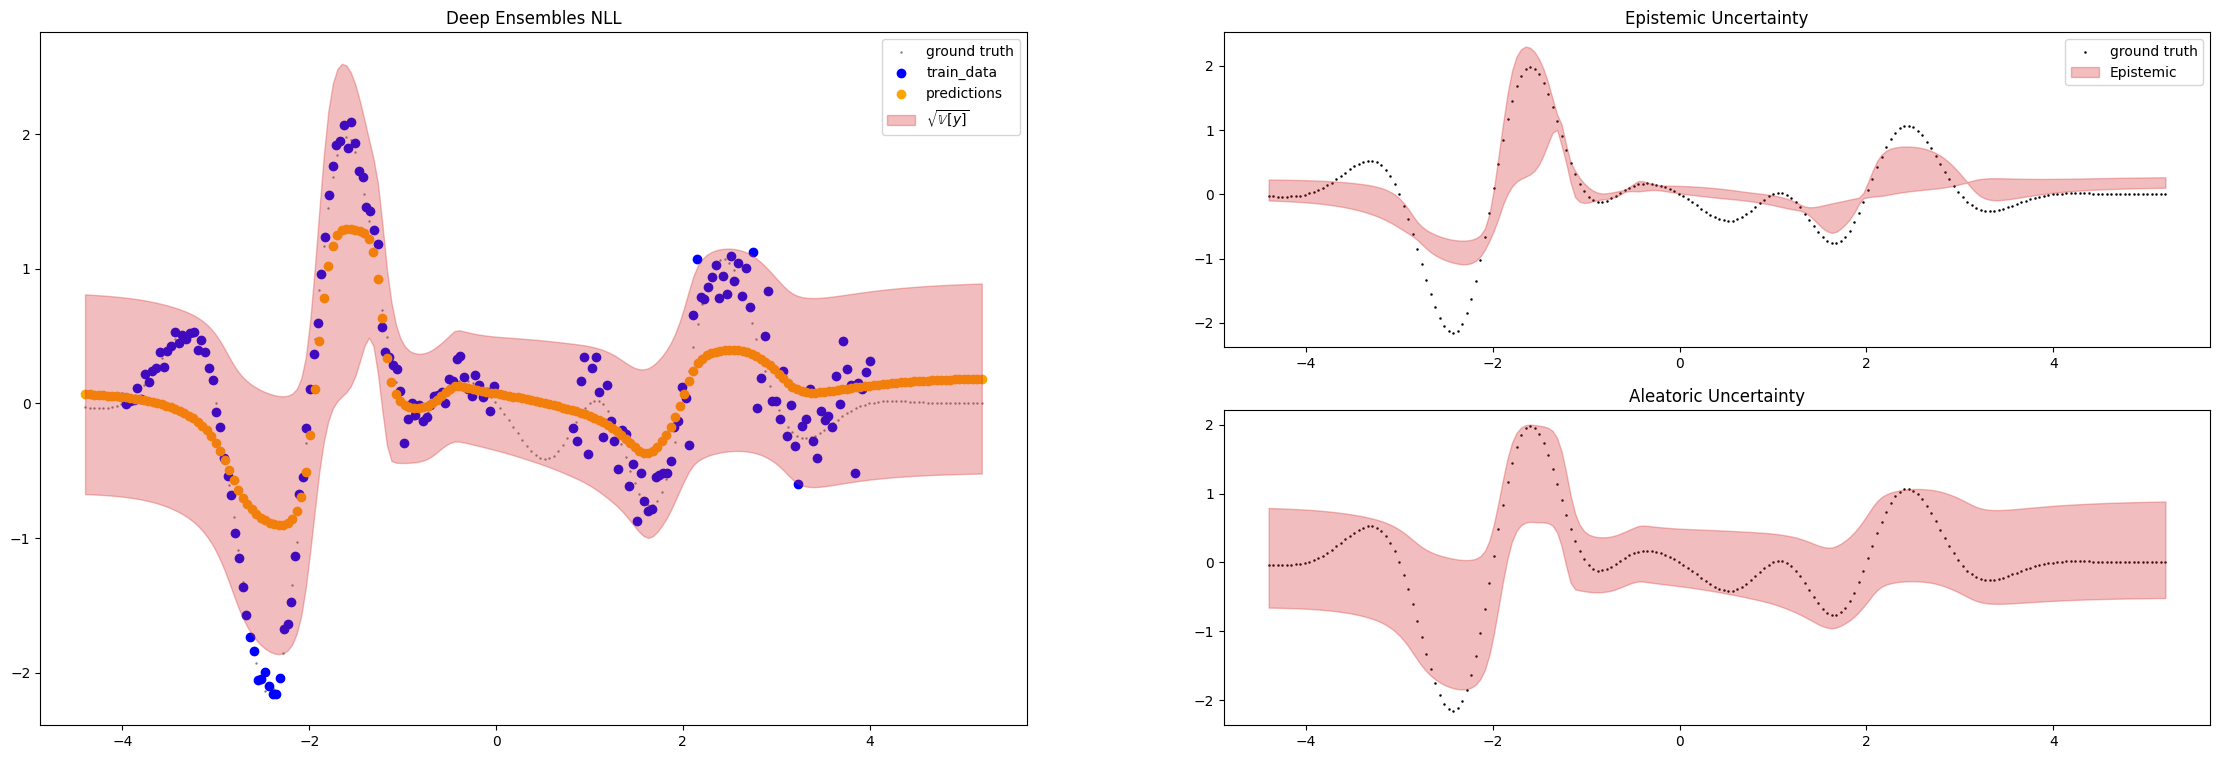

<Figure size 2800x900 with 0 Axes>

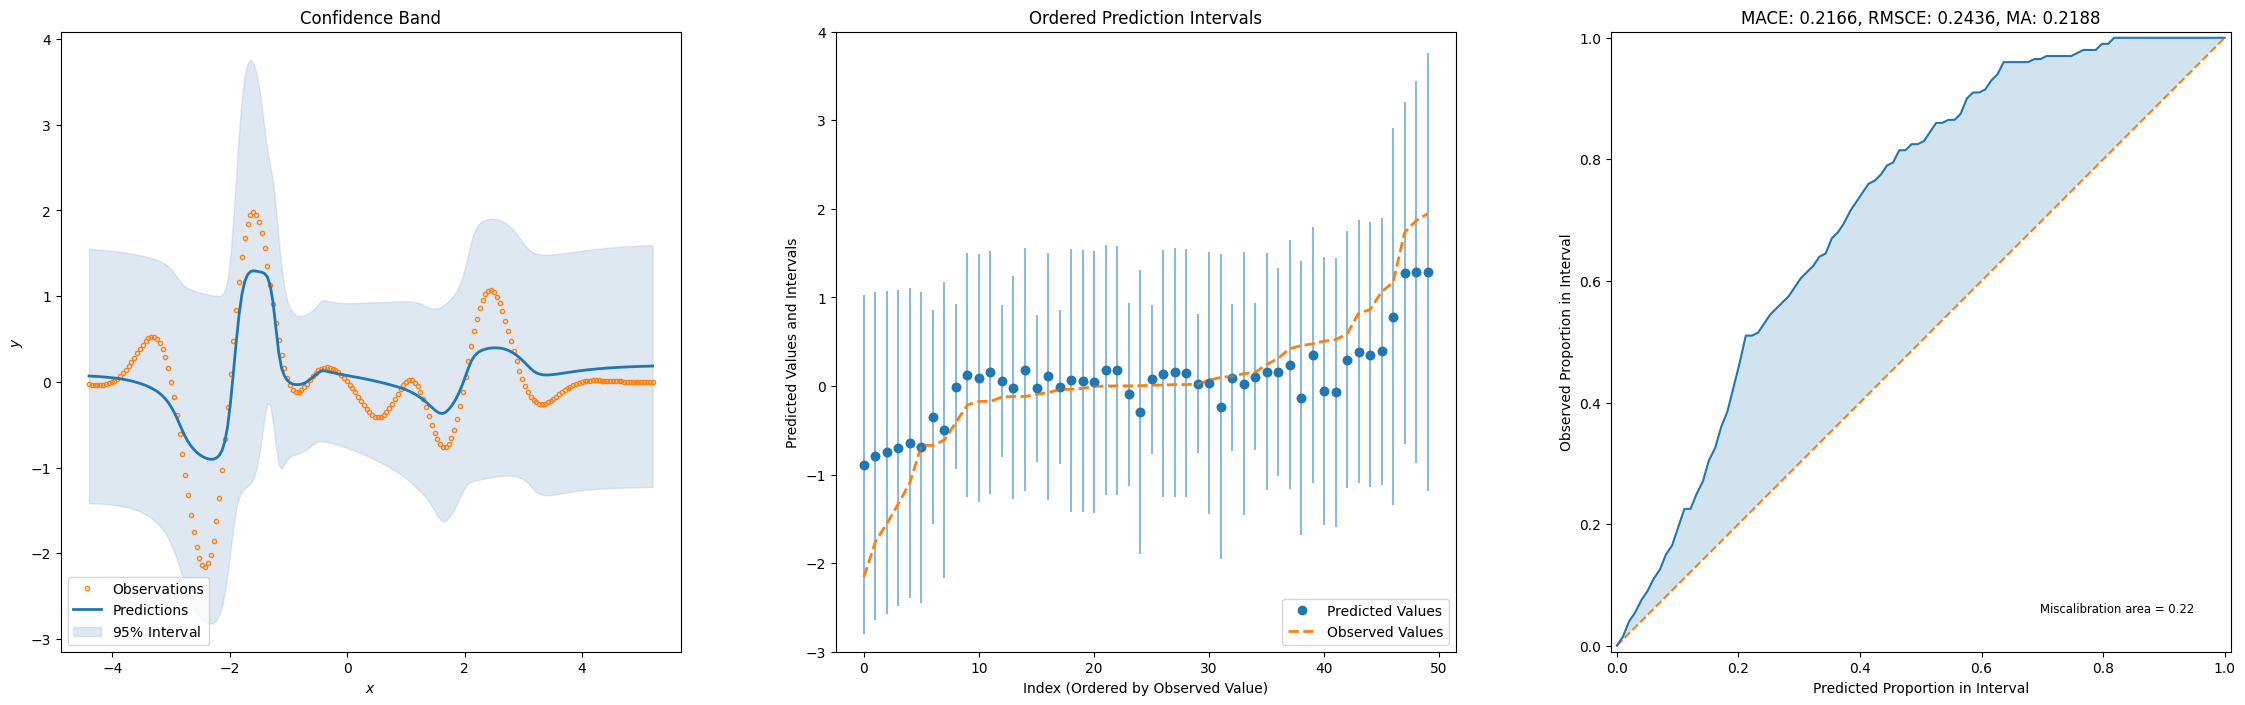

In [35]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    nll_de_mean,
    nll_de_std,
    epistemic=nll_epistemic_de,
    aleatoric=nll_aleatoric_de,
    title="Deep Ensembles NLL",
)
plot_calibration_uq_toolbox(nll_de_mean, nll_de_std, y_test_cpu, X_test_cpu)